In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage import io
import utils_xy
from torchvision import transforms, utils
import numpy as np
from PIL import Image
from random import randint
import time

In [2]:
gpu_id = 1
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

device = torch.device('cuda')
print (device)

cuda


In [3]:
img_dir = '/home/xiaoyu/BMMC/BMMCdata'
mask_dir = '/home/xiaoyu/BMMC/BMMCmasks'

img_list = sorted(os.listdir(img_dir))
mask_list = sorted(os.listdir(mask_dir))

print("Training images numbers: "+str(len(img_list)))
print("Training mask Images numbers:"+str(len(mask_list)))

Training images numbers: 43
Training mask Images numbers:43


In [4]:
class TrainDataset(Dataset):
    """Training dataset with mask image mapping to classes"""
    def __init__(self, img_dir, mask_dir, transform=None):
        """
        Args:
            train_dir (string): Directory with training images
            transform (callable): Optional transform to be applied on a sample
            semantic_dir (string): Directory with semantic segmentation training image
        """
        self.img_dir = img_dir
        self.transform = transform
        self.mask_dir = mask_dir
        
        
    def __len__(self):
        img_list = os.listdir(self.img_dir)
        return len(img_list)
    
    def __getitem__(self, idx):
        img_list = sorted(os.listdir(img_dir))
        mask_list = sorted(os.listdir(mask_dir))
        
        img_str = img_list[idx]
        img_arr = io.imread(os.path.join(img_dir, img_str))
        img_tensor = torch.from_numpy(np.uint8(img_arr))
        img_tensor = img_tensor.permute(2,0,1)
        
        mask_str = mask_list[idx]
        mask_arr = io.imread(os.path.join(mask_dir, mask_str))
        mask_tensor = torch.from_numpy(mask_arr)
        
        # after the compose, the mask value range is [0,1], the data type is torch.float32
        compose = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize((384,384),interpolation=Image.NEAREST), 
                                      transforms.ToTensor()])
        
        mask_tensor = torch.unsqueeze(mask_tensor, dim = 0)
        mask_tensor = compose(mask_tensor)
        mask_tensor = mask_tensor.squeeze()
        
        mask_tensor = torch.round(mask_tensor / 0.3).byte()-1
      
        sample = {'image':img_tensor, 'mask':mask_tensor}
        
        if self.transform:
            image = self.transform(img_tensor)
            sample = {'image':image, 'mask':mask_tensor}
        return sample

In [24]:
compose = transforms.Compose([transforms.ToPILImage(), transforms.Resize((384,384),interpolation=Image.NEAREST),
                              transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = TrainDataset(img_dir=img_dir, mask_dir = mask_dir)

transformed_dataset = TrainDataset(img_dir=img_dir, mask_dir = mask_dir, transform = compose)

dataloader = DataLoader(transformed_dataset, batch_size = 4, shuffle = True, num_workers = 4)

In [6]:
for i_batch, sample_batched in enumerate(dataloader):
    inputs, labels = sample_batched['image'], sample_batched['mask']
    print(inputs.size())
    print(labels.size())
    if i_batch ==1:
        break

torch.Size([4, 3, 384, 384])
torch.Size([4, 384, 384])
torch.Size([4, 3, 384, 384])
torch.Size([4, 384, 384])


### Define Network

In [7]:
class DenseBlock(nn.Module):
    '''
    param:
    in_channel, out_channel
    '''

    def __init__(self, in_channel, out_channel):
        super(DenseBlock, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size = 5, padding = 2 ),
            nn.BatchNorm2d(out_channel),
            nn.PReLU()          
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(out_channel+in_channel, out_channel, kernel_size = 5, padding = 2 ),
            nn.BatchNorm2d(out_channel),
            nn.PReLU() 
        )
        
        self.outconv = nn.Conv2d(2*out_channel+in_channel, out_channel, kernel_size = 1)
        
    def forward(self, x):
        x1 = self.block1(x)
        x2 = torch.cat((x, x1), dim=1)
        x3 = self.block2(x2)
        x4 = torch.cat((x,x1,x3), dim=1)
        
        out = self.outconv(x4)
        
        return out

In [8]:
class down(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(down, self).__init__()
        self.maxpool = nn.MaxPool2d(2, stride = 2, return_indices=True)
        self.conv = DenseBlock(in_channel, out_channel)     
                   
    def forward(self, x):
        x1, indices = self.maxpool(x)
        x1 = self.conv(x1)
        return x1, indices

In [9]:
class BottleNeck(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(BottleNeck, self).__init__()
        
        self.pool = nn.MaxPool2d(2, stride = 2, return_indices=True)
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size = 5, padding = 2)
        self.BatchNorm = nn.BatchNorm2d(out_channel)
       
    def forward(self,x):
        x , indices = self.pool(x)
        x = self.conv(x)
        x = self.BatchNorm(x)
        return x, indices

In [10]:
class up(nn.Module):
    def __init__(self, in_channel, out_channel ):
        super(up, self).__init__()
        self.unpool = nn.MaxUnpool2d(2, stride=2)
        self.conv = DenseBlock(in_channel*2, out_channel)
      
    
    def forward(self, x1, x2, indice = None, output_size=None):
        x1 = self.unpool(x1, indice, output_size)
        x = torch.cat([x1,x2], dim = 1)
        x = self.conv(x)
        
        return x

In [11]:
class OutConv(nn.Module):
    def __init__(self, in_channel, out_classes):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channel, out_classes, 1)
    def forward(self,x):
        x = self.conv(x)
        return x

In [12]:
class Encoder(nn.Module):
    def __init__(self, in_channel, num_channel):
        super(Encoder, self).__init__()
        self.conv_in = DenseBlock(in_channel, num_channel)
        
        self.down1 = down(num_channel, num_channel)
        self.down2 = down(num_channel, num_channel)
        self.down3 = down(num_channel, num_channel) 
        
        self.BottleNeck = BottleNeck(num_channel, num_channel)
    def forward(self, x):
        x1 = self.conv_in(x)
        
        x2, idx1 = self.down1(x1)
        x3, idx2 = self.down2(x2)
        x4, idx3 = self.down3(x3)
        x5, idx4 = self.BottleNeck(x4)
        
        return x5, x4, x3, x2, x1, idx1, idx2, idx3, idx4

In [13]:
class Decoder(nn.Module):
    def __init__(self, in_channel, out_class):
        super(Decoder, self).__init__()
        
        self.up1 = up(in_channel, in_channel)
        self.up2 = up(in_channel, in_channel)
        self.up3 = up(in_channel, in_channel)
        self.up4 = up(in_channel, in_channel)
        self.conv_out = OutConv(in_channel, out_class)

    
    def forward(self,x, idx1, idx2, idx3, idx4, x4,x3,x2,x1):
        x = self.up1.forward(x,x4,idx4)
        x = self.up2.forward(x,x3,idx3)
        x = self.up3.forward(x,x2,idx2)
        x = self.up4.forward(x,x1,idx1)
        x = self.conv_out(x)
        x = F.log_softmax(x, dim =1)
        return x       

In [14]:
class QuickNAT(nn.Module):
    def __init__(self, in_channel, num_channel, out_class):
        super(QuickNAT, self).__init__()
        self.in_channel = in_channel
        self.num_channel = num_channel
        self.out_class = out_class
        self.encoder = Encoder(self.in_channel, self.num_channel)
        self.decoder = Decoder(self.num_channel, self.out_class)
        
    def forward(self,x):
        x5, x4, x3, x2, x1, idx1, idx2, idx3, idx4 = self.encoder(x)
        x = self.decoder.forward(x5, idx1, idx2, idx3, idx4, x4,x3,x2,x1)
        return x

In [15]:
mynet = QuickNAT(3,64,3)
print(mynet)

model_params = list(mynet.parameters())

nb_param=0
for param in mynet.parameters():
    nb_param+=np.prod(list(param.data.size()))
print(nb_param)

QuickNAT(
  (encoder): Encoder(
    (conv_in): DenseBlock(
      (block1): Sequential(
        (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
      )
      (block2): Sequential(
        (0): Conv2d(67, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
      )
      (outconv): Conv2d(131, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (down1): down(
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv): DenseBlock(
        (block1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): PReLU(num_parameters

In [16]:
mynet = mynet.to(device)

In [17]:
criterion = nn.NLLLoss()

In [18]:
optimizer = optim.Adam(mynet.parameters() ,lr=0.001)

start=time.time()
for epoch in range(1,500): 

    # define the running loss
    running_loss = 0
    running_error = 0
    num_batches=0
      
    for i_batch, sample_batched in enumerate(dataloader):
        
        optimizer.zero_grad()
        
        #get the inputs
        inputs, labels = sample_batched['image'], sample_batched['mask']
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs.requires_grad_()
        
        #forward + backward +optimize
        mynet = mynet.cuda()
        scores = mynet(inputs)
    
        # Define the loss
        loss = criterion(scores, labels.long()) 
        loss.backward()
        optimizer.step()
        
        # compute and accumulate stats
        running_loss += loss.detach().item()
       
        num_batches+=1 
    
    # AVERAGE STATS THEN DISPLAY    
    total_loss = running_loss/num_batches
   
    elapsed = (time.time()-start)/60
        
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t loss=', total_loss )

       
print('Finish Training')

epoch= 1 	 time= 0.10248407125473022 min 	 loss= 0.799228782003576
epoch= 2 	 time= 0.2041144053141276 min 	 loss= 0.5437417301264676
epoch= 3 	 time= 0.30570565462112426 min 	 loss= 0.4866434064778415
epoch= 4 	 time= 0.4077620585759481 min 	 loss= 0.4629780352115631
epoch= 5 	 time= 0.5103107651074728 min 	 loss= 0.4081613231788982
epoch= 6 	 time= 0.6130259752273559 min 	 loss= 0.34684366529638117
epoch= 7 	 time= 0.7159168879191081 min 	 loss= 0.37782151861624286
epoch= 8 	 time= 0.8189999262491862 min 	 loss= 0.3862112381241538
epoch= 9 	 time= 0.9219400723775227 min 	 loss= 0.341636831110174
epoch= 10 	 time= 1.0259384353955587 min 	 loss= 0.31275300681591034
epoch= 11 	 time= 1.1293115019798279 min 	 loss= 0.32116483693773096
epoch= 12 	 time= 1.2326617916425069 min 	 loss= 0.2969786294481971
epoch= 13 	 time= 1.335619334379832 min 	 loss= 0.3007758869366212
epoch= 14 	 time= 1.4394396781921386 min 	 loss= 0.29185744578188116
epoch= 15 	 time= 1.5432870745658875 min 	 loss= 0.28

epoch= 122 	 time= 12.652266502380371 min 	 loss= 0.04484184594316916
epoch= 123 	 time= 12.756393778324128 min 	 loss= 0.0430122222751379
epoch= 124 	 time= 12.860400569438934 min 	 loss= 0.03952102041379972
epoch= 125 	 time= 12.964169176419576 min 	 loss= 0.03906546956436201
epoch= 126 	 time= 13.068484989802043 min 	 loss= 0.04412678815424442
epoch= 127 	 time= 13.172895101706187 min 	 loss= 0.04210851951078935
epoch= 128 	 time= 13.276557338237762 min 	 loss= 0.04033167558637532
epoch= 129 	 time= 13.380173420906067 min 	 loss= 0.04117064906114882
epoch= 130 	 time= 13.484058570861816 min 	 loss= 0.03545800173147158
epoch= 131 	 time= 13.588295944531758 min 	 loss= 0.0367472879588604
epoch= 132 	 time= 13.693053503831228 min 	 loss= 0.035942051390355285
epoch= 133 	 time= 13.797026884555816 min 	 loss= 0.04200115291909738
epoch= 134 	 time= 13.901265132427216 min 	 loss= 0.03802419403059916
epoch= 135 	 time= 14.004382312297821 min 	 loss= 0.03793396766890179
epoch= 136 	 time= 14

epoch= 239 	 time= 24.812082238992055 min 	 loss= 0.019895498725500973
epoch= 240 	 time= 24.916782029469807 min 	 loss= 0.02158908029510216
epoch= 241 	 time= 25.02114931344986 min 	 loss= 0.019140933216972786
epoch= 242 	 time= 25.125127585728965 min 	 loss= 0.018126231194897133
epoch= 243 	 time= 25.229133129119873 min 	 loss= 0.01758484093641693
epoch= 244 	 time= 25.332643282413482 min 	 loss= 0.0178163984621113
epoch= 245 	 time= 25.43629400730133 min 	 loss= 0.01716519993814555
epoch= 246 	 time= 25.54033149878184 min 	 loss= 0.01658104554834691
epoch= 247 	 time= 25.644011529286704 min 	 loss= 0.016989884644069454
epoch= 248 	 time= 25.747963619232177 min 	 loss= 0.01684722922403704
epoch= 249 	 time= 25.85172328154246 min 	 loss= 0.01642288157547062
epoch= 250 	 time= 25.956149113178252 min 	 loss= 0.016909663565456867
epoch= 251 	 time= 26.060811646779378 min 	 loss= 0.015819222496991806
epoch= 252 	 time= 26.16484458843867 min 	 loss= 0.01555321475660259
epoch= 253 	 time= 2

epoch= 356 	 time= 36.960970588525136 min 	 loss= 0.011579323179003868
epoch= 357 	 time= 37.064761964480084 min 	 loss= 0.01175633098252795
epoch= 358 	 time= 37.16931331157684 min 	 loss= 0.011522651480680162
epoch= 359 	 time= 37.2735910654068 min 	 loss= 0.011807481080970982
epoch= 360 	 time= 37.377802801132205 min 	 loss= 0.012433607766235416
epoch= 361 	 time= 37.48197849591573 min 	 loss= 0.0118950977074829
epoch= 362 	 time= 37.586674908796944 min 	 loss= 0.011330545414239168
epoch= 363 	 time= 37.69063773552577 min 	 loss= 0.011331054466691885
epoch= 364 	 time= 37.79462279478709 min 	 loss= 0.012056611055000261
epoch= 365 	 time= 37.898935500780745 min 	 loss= 0.01158450518480756
epoch= 366 	 time= 38.00350019137065 min 	 loss= 0.011320230635729704
epoch= 367 	 time= 38.10729911327362 min 	 loss= 0.010829754935746843
epoch= 368 	 time= 38.20945416291555 min 	 loss= 0.011378998233174736
epoch= 369 	 time= 38.31212404171626 min 	 loss= 0.01103165347806432
epoch= 370 	 time= 38

epoch= 473 	 time= 49.13435876766841 min 	 loss= 0.004996909717605872
epoch= 474 	 time= 49.238174537817635 min 	 loss= 0.004829977871850133
epoch= 475 	 time= 49.34205708106359 min 	 loss= 0.0048509286081587725
epoch= 476 	 time= 49.4455628712972 min 	 loss= 0.004520392870869149
epoch= 477 	 time= 49.549765471617384 min 	 loss= 0.004463122691959143
epoch= 478 	 time= 49.65411293506622 min 	 loss= 0.004589587513526732
epoch= 479 	 time= 49.75789896249771 min 	 loss= 0.004482030318203298
epoch= 480 	 time= 49.86163641214371 min 	 loss= 0.00467495355670425
epoch= 481 	 time= 49.965662972132364 min 	 loss= 0.004540685098618269
epoch= 482 	 time= 50.070088640848795 min 	 loss= 0.004722989058460702
epoch= 483 	 time= 50.17492888768514 min 	 loss= 0.005327019141986966
epoch= 484 	 time= 50.27868332862854 min 	 loss= 0.004837431839074601
epoch= 485 	 time= 50.383901516596474 min 	 loss= 0.005151993489231576
epoch= 486 	 time= 50.48815769354503 min 	 loss= 0.004730241203849966
epoch= 487 	 tim

In [21]:
def show_mask(image, mask):
    """
    Show image and mask
    Args:
        image(numpyarray): The training image
        semantic(numpyarray): The training image semantic segmentation
    """    
    plt.subplot(1,2,1)
    plt.title('image')
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.title('mask')
    plt.imshow(mask)
    plt.show()

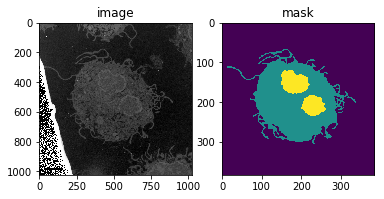

torch.Size([384, 384, 3])
tensor(1.)
tensor(0.)


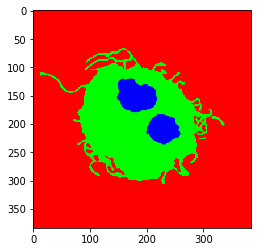

In [27]:
sample=train_data[0]
img = sample['image']
mask = sample['mask']

show_mask(img.permute(1,2,0), mask)

compose = transforms.Compose([transforms.ToPILImage(), transforms.Resize((384,384),interpolation=Image.NEAREST),
                              transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
img = compose(img)

img = img.unsqueeze(dim = 0)
img = img.to(device)

# feed it to network
scores =  mynet(img)
scores = scores.detach().cpu().squeeze().permute(1,2,0)
print(scores.size())
print(torch.max(torch.exp(scores)))
print(torch.min(torch.exp(scores)))
plt.imshow(torch.exp(scores))